<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 4: Description

</div>


In [47]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/ML/BIO/HW4")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
# Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-11-06 13:15:08--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy.9’

normal.npy.9        100%[===================>]  62.50M  60.5MB/s    in 1.0s    

2023-11-06 13:15:09 (60.5 MB/s) - ‘normal.npy.9’ saved [65536128/65536128]

--2023-11-06 13:15:09--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

## A. Data Loading and Preprocessing

In [49]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'abnormal_scans shape: {abnormal_scans.shape}, normal_scans shape: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')
print(f'abnormal_labels shape: {abnormal_labels.shape}, normal_labels shape: {normal_labels.shape}')

abnormal_scans shape: (1000, 256, 256), normal_scans shape: (1000, 256, 256)
X_train: max value is 255, min value is 0, data type is uint8.
abnormal_labels shape: (1000,), normal_labels shape: (1000,)


# B.Data Preprocessing

In [50]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class MedicalDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()

        # Define the default transformations if none are provided
        self.transform = transform or transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Grayscale(num_output_channels=3),  # Converts 1-channel grayscale to 3-channel
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # Convert the numpy array to a PIL image
        image = Image.fromarray(self.x[idx])

        # Apply the transformations to the PIL image
        if self.transform:
            image = self.transform(image)

        return image, self.y[idx]

In [51]:
batch_size = 64

train_dataset = MedicalDataset(x_train, y_train)
val_dataset = MedicalDataset(x_val, y_val)
test01, test02 = train_dataset[1]
print(test01.shape)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

torch.Size([3, 224, 224])


# Show dataset image

abnormal:



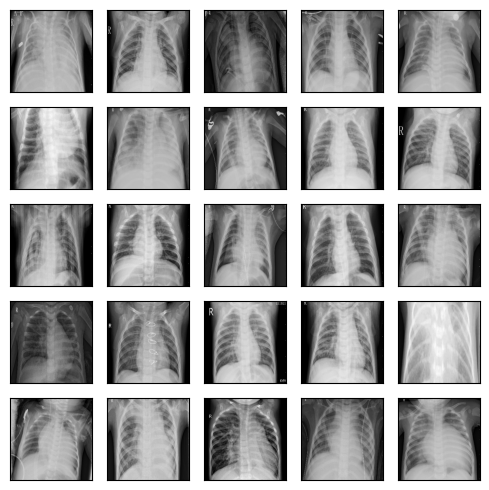

normal:



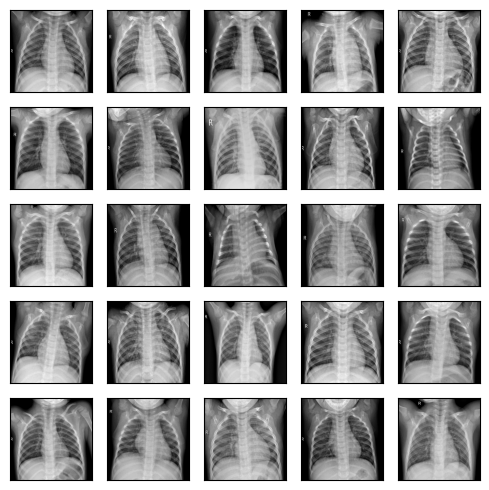

In [52]:
import matplotlib.pyplot as plt

def plot_images(images, num_images=25):
    # Set the figure size
    plt.figure(figsize=(5,5))
    # Loop through the first 25 images
    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(5, 5, i+1)
        plt.xticks([])  # Remove x-axis tick marks
        plt.yticks([])  # Remove y-axis tick marks
        plt.grid(False)  # Hide gridlines
        plt.imshow(images[i], cmap=plt.cm.gray)  # Show the image in grayscale

        # You could add titles or other customizations here
        # plt.title(f"Image {i+1}")

    # Adjust the layout
    plt.tight_layout()
    plt.show()
print('abnormal:\n')
plot_images(abnormal_scans)
print('normal:\n')
plot_images(normal_scans)

# Task B01. Fine Tunning ResNet18

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the pre-trained ResNet-18 model
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# 2. Modify the fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Change the output features to 2
model.to(device)

# 3. Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized as
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


# Fine tune the model




In [54]:
import matplotlib.pyplot as plt
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists to store loss and accuracy values
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the loss and accuracy for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                # Save the model if it's the best on validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)

Epoch 1/10
----------
Train Loss: 0.5216 Acc: 0.7469
Val Loss: 0.6953 Acc: 0.5700
Epoch 2/10
----------
Train Loss: 0.2779 Acc: 0.8931
Val Loss: 0.7801 Acc: 0.5825
Epoch 3/10
----------
Train Loss: 0.2430 Acc: 0.9106
Val Loss: 0.2519 Acc: 0.9150
Epoch 4/10
----------
Train Loss: 0.2184 Acc: 0.9181
Val Loss: 0.2072 Acc: 0.9450
Epoch 5/10
----------
Train Loss: 0.2027 Acc: 0.9287
Val Loss: 0.1985 Acc: 0.9400
Epoch 6/10
----------
Train Loss: 0.1942 Acc: 0.9319
Val Loss: 0.1935 Acc: 0.9375
Epoch 7/10
----------
Train Loss: 0.1923 Acc: 0.9331
Val Loss: 0.1829 Acc: 0.9475
Epoch 8/10
----------
Train Loss: 0.1838 Acc: 0.9344
Val Loss: 0.1771 Acc: 0.9500
Epoch 9/10
----------
Train Loss: 0.1716 Acc: 0.9381
Val Loss: 0.1832 Acc: 0.9400
Epoch 10/10
----------
Train Loss: 0.1736 Acc: 0.9387
Val Loss: 0.1677 Acc: 0.9500
Best val Acc: 0.9500


# Loss and Acc visualization

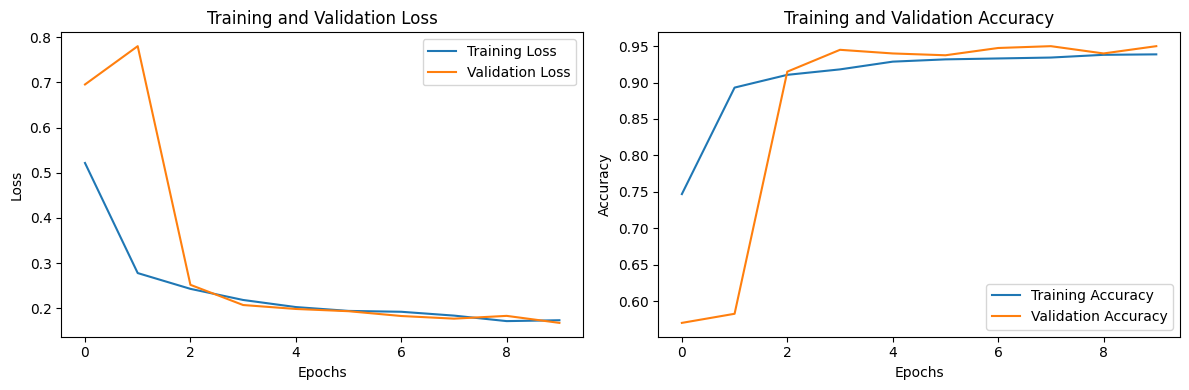

In [55]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Task B02. Fine Tunning DenseNet

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DenseNet model
model = models.densenet121(weights=True)  # Make sure to set pretrained to True

In [61]:
# Replace the classifier with a new one for binary classification
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)  # Binary classification so output is 2

# Move the model to the device (GPU or CPU)
model = model.to(device)
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - If you want to fine-tune the whole model, you can use model.parameters() instead of model.classifier.parameters()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

In [62]:
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
Train Loss: 0.5735 Acc: 0.7100
Val Loss: 0.4228 Acc: 0.8700
Epoch 2/10
----------
Train Loss: 0.3072 Acc: 0.9012
Val Loss: 0.2943 Acc: 0.9125
Epoch 3/10
----------
Train Loss: 0.2328 Acc: 0.9287
Val Loss: 0.2430 Acc: 0.9150
Epoch 4/10
----------
Train Loss: 0.2098 Acc: 0.9325
Val Loss: 0.2275 Acc: 0.9150
Epoch 5/10
----------
Train Loss: 0.1892 Acc: 0.9400
Val Loss: 0.2158 Acc: 0.9200
Epoch 6/10
----------
Train Loss: 0.1832 Acc: 0.9363
Val Loss: 0.2036 Acc: 0.9275
Epoch 7/10
----------
Train Loss: 0.1660 Acc: 0.9494
Val Loss: 0.1971 Acc: 0.9225
Epoch 8/10
----------
Train Loss: 0.1656 Acc: 0.9456
Val Loss: 0.2048 Acc: 0.9200
Epoch 9/10
----------
Train Loss: 0.1651 Acc: 0.9413
Val Loss: 0.1954 Acc: 0.9225
Epoch 10/10
----------
Train Loss: 0.1534 Acc: 0.9475
Val Loss: 0.1901 Acc: 0.9225
Best val Acc: 0.9275


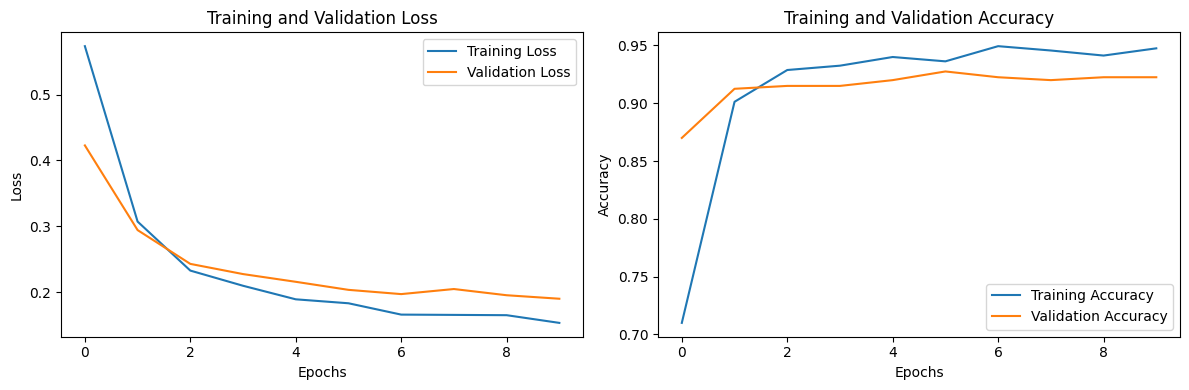

In [63]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Task C01. Feautre Extractor - ResNet18

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [65]:
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
Train Loss: 0.4880 Acc: 0.7806
Val Loss: 0.4489 Acc: 0.8175
Epoch 2/10
----------
Train Loss: 0.2647 Acc: 0.9075
Val Loss: 0.4681 Acc: 0.7525
Epoch 3/10
----------
Train Loss: 0.2216 Acc: 0.9225
Val Loss: 0.2385 Acc: 0.9025
Epoch 4/10
----------
Train Loss: 0.2102 Acc: 0.9188
Val Loss: 0.2257 Acc: 0.9075
Epoch 5/10
----------
Train Loss: 0.2027 Acc: 0.9269
Val Loss: 0.2004 Acc: 0.9250
Epoch 6/10
----------
Train Loss: 0.1917 Acc: 0.9325
Val Loss: 0.1891 Acc: 0.9400
Epoch 7/10
----------
Train Loss: 0.1873 Acc: 0.9350
Val Loss: 0.1831 Acc: 0.9425
Epoch 8/10
----------
Train Loss: 0.1778 Acc: 0.9381
Val Loss: 0.1773 Acc: 0.9425
Epoch 9/10
----------
Train Loss: 0.1743 Acc: 0.9431
Val Loss: 0.1746 Acc: 0.9450
Epoch 10/10
----------
Train Loss: 0.1752 Acc: 0.9356
Val Loss: 0.1736 Acc: 0.9425
Best val Acc: 0.9450


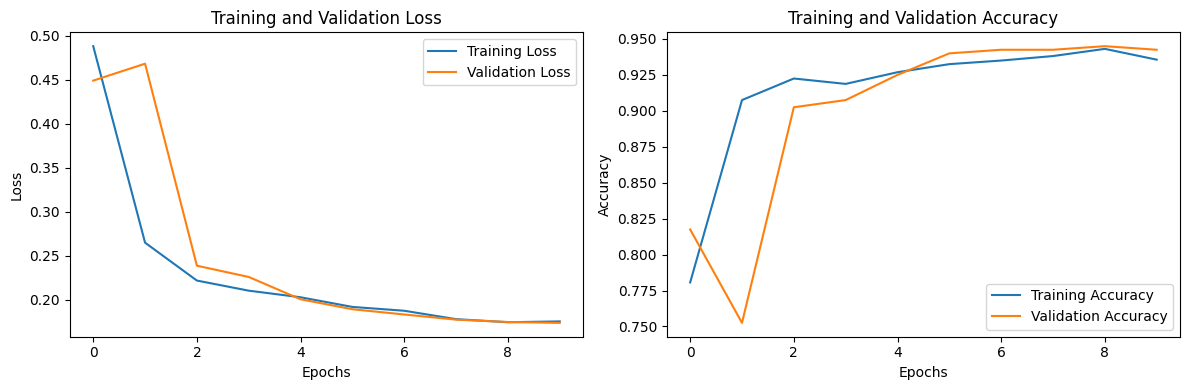

In [66]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Task C02. Feautre Extractor - DenseNet

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Freeze all the layers by disabling gradient computation
for param in model.parameters():
    param.requires_grad = False

# DenseNet uses a classifier called `classifier` instead of `fc` like in ResNet
num_ftrs = model.classifier.in_features
# Replace the classifier with a new one for binary classification
model.classifier = nn.Linear(num_ftrs, 2)

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Define the loss function and optimizer
# Only parameters of the final layer are being optimized
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

In [68]:
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
Train Loss: 0.5944 Acc: 0.6987
Val Loss: 0.4488 Acc: 0.8025
Epoch 2/10
----------
Train Loss: 0.3054 Acc: 0.9125
Val Loss: 0.2756 Acc: 0.9075
Epoch 3/10
----------
Train Loss: 0.2404 Acc: 0.9225
Val Loss: 0.2336 Acc: 0.9175
Epoch 4/10
----------
Train Loss: 0.2149 Acc: 0.9306
Val Loss: 0.2255 Acc: 0.9125
Epoch 5/10
----------
Train Loss: 0.1889 Acc: 0.9350
Val Loss: 0.2175 Acc: 0.9175
Epoch 6/10
----------
Train Loss: 0.1884 Acc: 0.9306
Val Loss: 0.1984 Acc: 0.9300
Epoch 7/10
----------
Train Loss: 0.1685 Acc: 0.9500
Val Loss: 0.1950 Acc: 0.9225
Epoch 8/10
----------
Train Loss: 0.1587 Acc: 0.9463
Val Loss: 0.1855 Acc: 0.9275
Epoch 9/10
----------
Train Loss: 0.1582 Acc: 0.9500
Val Loss: 0.1850 Acc: 0.9225
Epoch 10/10
----------
Train Loss: 0.1530 Acc: 0.9525
Val Loss: 0.1783 Acc: 0.9400
Best val Acc: 0.9400


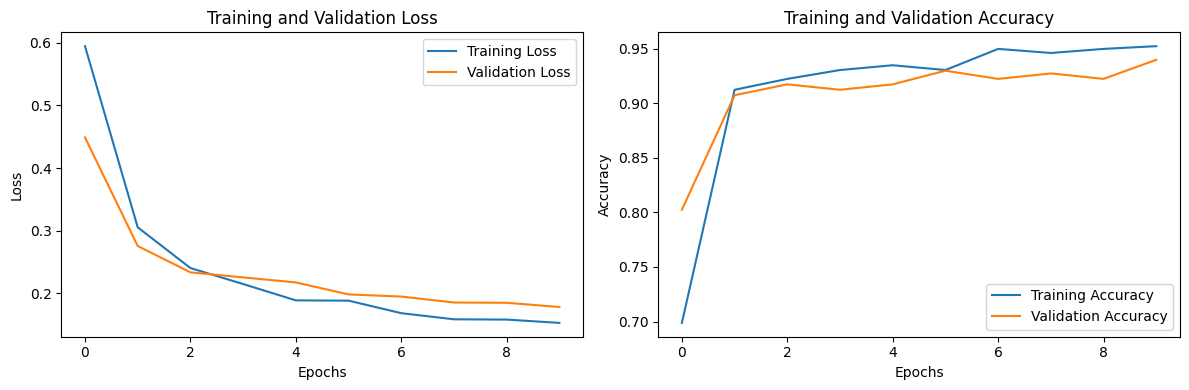

In [69]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()